# Implementation of HED in Pytorch
---


In [2]:
# import torch libraries
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import os
import numpy as np
import pandas as pd
from PIL import Image
import skimage.io as io
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# import utility functions
from model import *
from trainer import Trainer
from dataproc import TrainDataset

In [3]:
# fix random seed
rng = np.random.RandomState(37148)

# GPU ID
gpuID = 0

### Inspect Training Data

In [4]:
# load the images dataset
dataRoot = 'data/HED-BSDS/'
trainPath = dataRoot+'train_pair.lst'

rootDir = dataRoot
frame = pd.read_csv(trainPath, dtype=str, delimiter=' ')

# check some sample images
idx = 1

# input and target images
inputName = os.path.join(rootDir, frame.iloc[idx, 0])
targetName = os.path.join(rootDir, frame.iloc[idx, 1])        

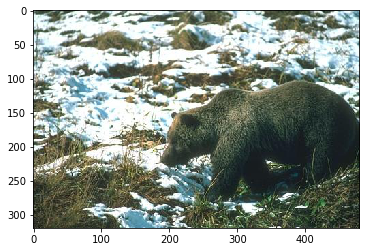

In [5]:
# process the images
inputImage = np.asarray(Image.open(inputName).convert('RGB'))

crop = 32
inputImage = inputImage[crop:-crop,crop:-crop,:]

plt.figure()
plt.imshow(inputImage)
plt.show()

inputImage = inputImage.astype(np.float32)
inputImage = inputImage/255.0
#inputImage = inputImage[:,:,::-1]
inputImage -= np.array((0.485, 0.456, 0.406))
inputImage /= np.array((0.229, 0.224, 0.225))        

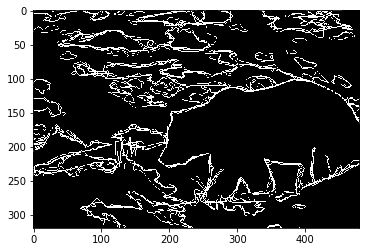

In [6]:
# process input and target images
targetImage = io.imread(targetName)

crop = 32
targetImage = targetImage[crop:-crop,crop:-crop,:]

if len(targetImage.shape) == 3:
    targetImage = targetImage[:,:,0]
targetImage = targetImage/255.0
targetImage = targetImage > 0.0
targetImage = targetImage.astype(np.float32)

plt.figure()
plt.imshow(targetImage,cmap=cm.gray)
plt.show()

### Train the Network

In [6]:
# batch size
nBatch = 1

# load the images dataset
dataRoot = 'data/HED-BSDS/'
modelPath = 'model/vgg16.pth'
valPath = dataRoot+'val_pair.lst'
trainPath = dataRoot+'train_pair.lst'

# create data loaders from dataset

std=[0.229, 0.224, 0.225]
mean=[0.485, 0.456, 0.406]

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
            ])
targetTransform = transforms.Compose([
                transforms.ToTensor()
            ])

valDataset = TrainDataset(valPath, dataRoot, 
                          transform, targetTransform)
trainDataset = TrainDataset(trainPath, dataRoot, 
transform, targetTransform)

valDataloader = DataLoader(valDataset, shuffle=False)
trainDataloader = DataLoader(trainDataset, shuffle=True)


In [7]:
# initialize the network
net = HED()
net.apply(weights_init)

pretrained_dict = torch.load(modelPath)
pretrained_dict = convert_vgg(pretrained_dict)

model_dict = net.state_dict()
model_dict.update(pretrained_dict)
net.load_state_dict(model_dict)

# loaded_dict = net.state_dict()
# print(loaded_dict)
# for k,v in loaded_dict.items():
#     print(k)
net.cuda(gpuID)


# define the optimizer
lr = 1e-4
lrDecay = 1e-1
lrDecayEpoch = {3,5,8,10,12}

fuse_params = list(map(id, net.fuse.parameters()))
conv5_params = list(map(id, net.conv5.parameters()))
base_params = filter(lambda p: id(p) not in conv5_params+fuse_params,
                     net.parameters())

optimizer = torch.optim.SGD([
            {'params': base_params},
            {'params': net.conv5.parameters(), 'lr': lr * 100},
            {'params': net.fuse.parameters(), 'lr': lr * 0.001}
            ], lr=lr, momentum=0.9)



# optimizer = optim.SGD(net.parameters(), lr=1e-6, momentum=0.9, weight_decay=0.0002)

Conv2d
ReLU
Conv2d
ReLU
Sequential
MaxPool2d
Conv2d
ReLU
Conv2d
ReLU
Sequential
MaxPool2d
Conv2d
ReLU
Conv2d
ReLU
Conv2d
ReLU
Sequential
MaxPool2d
Conv2d
ReLU
Conv2d
ReLU
Conv2d
ReLU
Sequential
MaxPool2d
Conv2d
ReLU
Conv2d
ReLU
Conv2d
ReLU
Sequential
Conv2d
Conv2d
Conv2d
Conv2d
Conv2d
Conv2d
HED


In [8]:
# initialize trainer class
trainer = Trainer(net, optimizer, trainDataloader, valDataloader, 
                  nBatch=nBatch, maxEpochs=15, cuda=True, gpuID=gpuID,
lrDecayEpochs=lrDecayEpoch)

from tensorboard_logger import configure

# train the network
trainer.train()
# if os.path.exists(self.out + '/log') == False:
#     os.mkdir(self.out + '/log')


15
[success]=> loaded checkpoint 'train/epoch14.pth' (epoch 15)
[success]=> already reached max epoch 15


Augment Training with Glyph Data
=============================

In [7]:
#glyph root
import glob
import cv2
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

mayaRoot = 'data/codex_dresdensis'
glyphDir = mayaRoot +'/glyphs'
blockDir = mayaRoot +'/blocks'

glyphlist = glob.glob(glyphDir + "/*.png")
blocklist = glob.glob(blockDir + "/*.png")


dataset = glyphlist + blocklist
print(dataset[:10])
# dataset = []
# for fname in (glyphlist + blocklist):
#     img = Image.open(fname)
#     dataset.append((fname, img))

['data/codex_dresdensis/glyphs/9_27.png', 'data/codex_dresdensis/glyphs/9_22.png', 'data/codex_dresdensis/glyphs/16_25.png', 'data/codex_dresdensis/glyphs/10_14.png', 'data/codex_dresdensis/glyphs/11_7.png', 'data/codex_dresdensis/glyphs/12_25.png', 'data/codex_dresdensis/glyphs/13_7.png', 'data/codex_dresdensis/glyphs/10_4.png', 'data/codex_dresdensis/glyphs/14_3.png', 'data/codex_dresdensis/glyphs/8_1.png']


Preprocess all input images
-----------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TEST FILENAME:  data/codex_dresdensis/glyphs/11_10.png


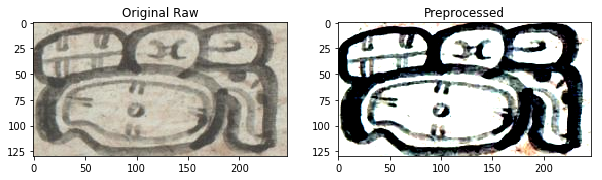

Preprocessed np.array has shape (130, 247, 3) and dtype float32


In [9]:



def preprocess_input_img(inputImage):
    #Norm and mean shift
    inputImage = inputImage.astype(np.float32)
    inputImage = inputImage/255.0
    #inputImage = inputImage[:,:,::-1]
    inputImage -= np.array((0.485, 0.456, 0.406))
    inputImage /= np.array((0.229, 0.224, 0.225))
    return inputImage
#     #Rebound back to [0, 255]
#     im = Image.fromarray(inputImage)
#     if im.mode != 'RGB':
#         im = im.convert('RGB')
#     im.save((output_fname))
#     return im 
   
test_file = dataset[13]
print('TEST FILENAME: ', test_file)

test_img_PIL = Image.open(test_file).convert('RGB')
test_img_PPd = preprocess_input_img(np.asarray(test_img_PIL))
    

images = [test_img_PIL, test_img_PPd]
titles = ['Original Raw', 'Preprocessed']

plt.figure(figsize=(10, 8))

for i, (title, img) in enumerate(zip(titles, images)):
    plt.subplot(1,2,i+1)
    plt.title(title)     
    plt.imshow(img)
    
plt.show()
%matplotlib inline

print('Preprocessed np.array has shape {} and dtype {}'.format(test_img_PPd.shape, test_img_PPd.dtype))

Ground Truth Experimentation
-----------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

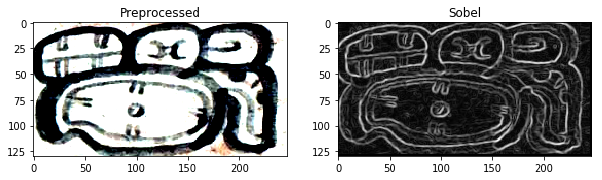

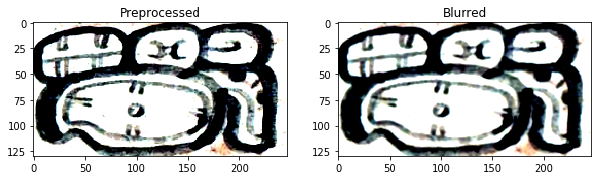

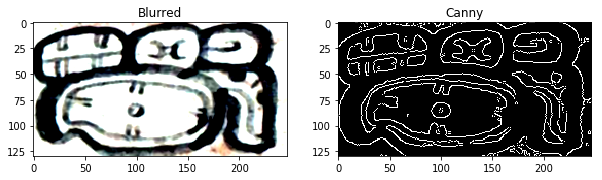

In [10]:


# NOT USED... too noisy
def sobel(img, output_fname, display=True, saveToDisk=True):
    # Sobel Operator
    h, w, d = img.shape

    # define filters
    GradientX = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])  # s2
    GradientY = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])  # s1

    # define images with 0s
    result = np.zeros_like(img)

    # offset by 1
    for channel in range(d):
        for i in range(1, h - 1):
            for j in range(1, w - 1):
                horizontalGrad = (GradientX[0, 0] * img[i - 1, j - 1, channel]) + \
                                 (GradientX[0, 1] * img[i - 1, j, channel]) + \
                                 (GradientX[0, 2] * img[i - 1, j + 1, channel]) + \
                                 (GradientX[1, 0] * img[i, j - 1, channel]) + \
                                 (GradientX[1, 1] * img[i, j, channel]) + \
                                 (GradientX[1, 2] * img[i, j + 1, channel]) + \
                                 (GradientX[2, 0] * img[i + 1, j - 1, channel]) + \
                                 (GradientX[2, 1] * img[i + 1, j, channel]) + \
                                 (GradientX[2, 2] * img[i + 1, j + 1, channel])

                verticalGrad = (GradientY[0, 0] * img[i - 1, j - 1, channel]) + \
                               (GradientY[0, 1] * img[i - 1, j, channel]) + \
                               (GradientY[0, 2] * img[i - 1, j + 1, channel]) + \
                               (GradientY[1, 0] * img[i, j - 1, channel]) + \
                               (GradientY[1, 1] * img[i, j, channel]) + \
                               (GradientY[1, 2] * img[i, j + 1, channel]) + \
                               (GradientY[2, 0] * img[i + 1, j - 1, channel]) + \
                               (GradientY[2, 1] * img[i + 1, j, channel]) + \
                               (GradientY[2, 2] * img[i + 1, j + 1, channel])

                # Edge Magnitude
                mag = np.sqrt(pow(horizontalGrad, 2.0) + pow(verticalGrad, 2.0))
                # Avoid underflow: clip result
                result[i - 1, j - 1, channel] = mag
    # now add the images r g and b
    rgb_edge = result[:,:,0] + result[:,:,1] + result[:,:,2]
    if display:
        images = [img, rgb_edge]
        titles = ['Preprocessed', 'Sobel']
        plt.figure(figsize=(10, 8))
        for i, (title, img) in enumerate(zip(titles, images)):
            plt.subplot(1,2,i+1)
            plt.title(title)     
            plt.imshow(img, cmap='gray')
    if saveToDisk:
        im = Image.fromarray(rgb_edge)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        im.save((output_fname))
    return rgb_edge
    
    

def canny(img, output_fname='', σ=0.25, display=True, saveToDisk=True):

    gauss_kernel = (3,3)
    blurred = cv2.GaussianBlur(img, gauss_kernel, 0)
    if display:
        images = [img, blurred]
        titles = ['Preprocessed', 'Blurred']
        plt.figure(figsize=(10, 8))
        for i, (title, img) in enumerate(zip(titles, images)):
            plt.subplot(1,2,i+1)
            plt.title(title)     
            plt.imshow(img)
    
    #Set threshold band to be within 1 +/- σ (standard dev)
    median = np.median(blurred)
    low_bound = (1 - σ) * median
    high_bound = (1 + σ) * median
    low_bound = max(0, low_bound)
    high_bound = min(255, high_bound)
    
    #Canny always expects dtype CV_u8 / uint8 so cast
    cast = np.uint8(blurred)
    edges = cv2.Canny(cast, low_bound, high_bound)
    if display:
        images = [blurred, edges]
        titles = ['Blurred', 'Canny']
        plt.figure(figsize=(10, 8))
        for i, (title, img) in enumerate(zip(titles, images)):
            plt.subplot(1,2,i+1)
            plt.title(title)     
            plt.imshow(img, cmap='gray')
    if saveToDisk:
        cv2.imwrite(output_fname, edges)
    return edges

        
        
# #[R, G, B] ====> [B, G, R] schema conversion
# test_img_openCV = cv2.cvtColor(np.array(test_img_PIL), cv2.COLOR_RGB2BGR)
        
sobel(test_img_PPd, output_fname=(test_file.split('.')[0] + '_groundSobel.png'), saveToDisk=False)
canny(test_img_PPd, output_fname=(test_file.split('.')[0] + '_groundCanny.png'), saveToDisk=False)
    
    

RUN CELL BELOW ONLY TO PRODUCE TRAIN/TEST PARTITIONS
==========================================

Too many img value clip warnings will flood the terminal and could take up a lot of resources leading to lag or non-response
--------------------------------------------------------------------------------------------------------------------

In [ ]:

#ONLY RUN TO PRODUCE TRAIN/TEST SET FOR GLYPHS

import random
import scipy.misc

trainRoot = mayaRoot + '/train/'
testRoot = mayaRoot + '/test/'


if os.path.exists(trainRoot) == False:
    os.mkdir(trainRoot)
if os.path.exists(testRoot) == False:
    os.mkdir(testRoot)
        

train = []
test = []
train_cutoff = int(len(dataset) * 0.8)
i = 0
random.shuffle(dataset)

for f in dataset:
    fbase, fext = os.path.basename(f).split('.')
    output_fname = fbase + '_GT.' + fext
    savePath = trainRoot if i <= train_cutoff else testRoot

    img = Image.open(f).convert('RGB')
    img_PPd = preprocess_input_img(np.asarray(img))

    processedPath = (savePath +os.path.basename(f))
    groundPath = (savePath+output_fname)
    if i <= train_cutoff:
        train.append(('train/'+os.path.basename(f), 'train/'+output_fname))
    else:
        test.append(('test/'+os.path.basename(f), 'test/'+output_fname))
    plt.imsave(processedPath, img_PPd)
    img_GT = canny(img_PPd, groundPath, display=False, saveToDisk=True)
    i += 1

with open(mayaRoot+'/train.lst', 'w') as trainList:
    for p, g in train:
        trainList.write('{} {}\n'.format(p, g))
    
with open(mayaRoot+'/test.lst', 'w') as testList:
    for p, g in test:
        testList.write('{} {}\n'.format(p, g))   
    


Start Training for MayaNet Transfer
-------------------------------------

In [9]:
glyphTrainPath = mayaRoot + '/train.lst'

transform = transforms.Compose([transforms.ToTensor()])
targetTransform = transforms.Compose([transforms.ToTensor()])

trainDataset = TrainDataset(glyphTrainPath, mayaRoot+'/', transform, targetTransform)
trainDataloader = DataLoader(trainDataset, shuffle=True)

Initialize Net (if Cells for base training above haven't been called, else Tensorboard Logging errors)
-----------------------------

In [10]:
net = HED()
net.cuda(gpuID)

# load the weights for the model
state = torch.load('train/glyphStart.pth')
net.load_state_dict(state['state_dict'])


# define the optimizer
lr = 1e-4
lrDecay = 1e-1
lrDecayEpoch = {3,5,8,10,12}

fuse_params = list(map(id, net.fuse.parameters()))
conv5_params = list(map(id, net.conv5.parameters()))
base_params = filter(lambda p: id(p) not in conv5_params+fuse_params,
                     net.parameters())

optimizer = torch.optim.SGD([
            {'params': base_params},
            {'params': net.conv5.parameters(), 'lr': lr * 100},
            {'params': net.fuse.parameters(), 'lr': lr * 0.001}
            ], lr=lr, momentum=0.9)


Train using glyphTrain = True
===========================

glyphTrain is used to write to separate checkpoints. Note that we load the net with a special checkpoint glyphStart.pth which is a renamed copy of epoch14.pth which is the highest training cycles acheived, ideally should be closer to 20

In [11]:
# initialize trainer class
trainer = Trainer(net, optimizer, trainDataloader, None, 
                  nBatch=1, maxEpochs=15, cuda=True, gpuID=gpuID,
lrDecayEpochs=lrDecayEpoch)


# train the network
trainer.train(glyphTrain=True, loadRecent=False)
# if os.path.exists(self.out + '/log') == False:
#     os.mkdir(self.out + '/log')

2019-06-05 01:32:54 epoch: 1 iter:100 loss:0.996330
2019-06-05 01:32:58 epoch: 1 iter:200 loss:0.859762
2019-06-05 01:33:01 epoch: 1 iter:300 loss:0.803979
2019-06-05 01:33:06 epoch: 2 iter:100 loss:0.800911
2019-06-05 01:33:09 epoch: 2 iter:200 loss:0.777369
2019-06-05 01:33:13 epoch: 2 iter:300 loss:0.757038
2019-06-05 01:33:18 epoch: 3 iter:100 loss:0.748932
2019-06-05 01:33:21 epoch: 3 iter:200 loss:0.772106
2019-06-05 01:33:24 epoch: 3 iter:300 loss:0.735118
2019-06-05 01:33:30 epoch: 4 iter:100 loss:0.757359
2019-06-05 01:33:33 epoch: 4 iter:200 loss:0.737019
2019-06-05 01:33:37 epoch: 4 iter:300 loss:0.745913
2019-06-05 01:33:42 epoch: 5 iter:100 loss:0.755020
2019-06-05 01:33:45 epoch: 5 iter:200 loss:0.743014
2019-06-05 01:33:49 epoch: 5 iter:300 loss:0.748845
2019-06-05 01:33:54 epoch: 6 iter:100 loss:0.750835
2019-06-05 01:33:57 epoch: 6 iter:200 loss:0.741797
2019-06-05 01:34:01 epoch: 6 iter:300 loss:0.745526
2019-06-05 01:34:06 epoch: 7 iter:100 loss:0.753619
2019-06-05 0